<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-MCD/blob/main/14-RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>RAG</h1>

<h3>Retrieval-augmented generation</h3>

RAG (*generación aumentada por recuperación*, por sus siglas en inglés) es una técnica que complementa la generación de texto con información de fuentes de datos. Combina un modelo de recuperación, que está diseñado para buscar en bases de conocimiento, con un modelo LLM, el cual que toma esa información y genera una respuesta en lenguaje natural.

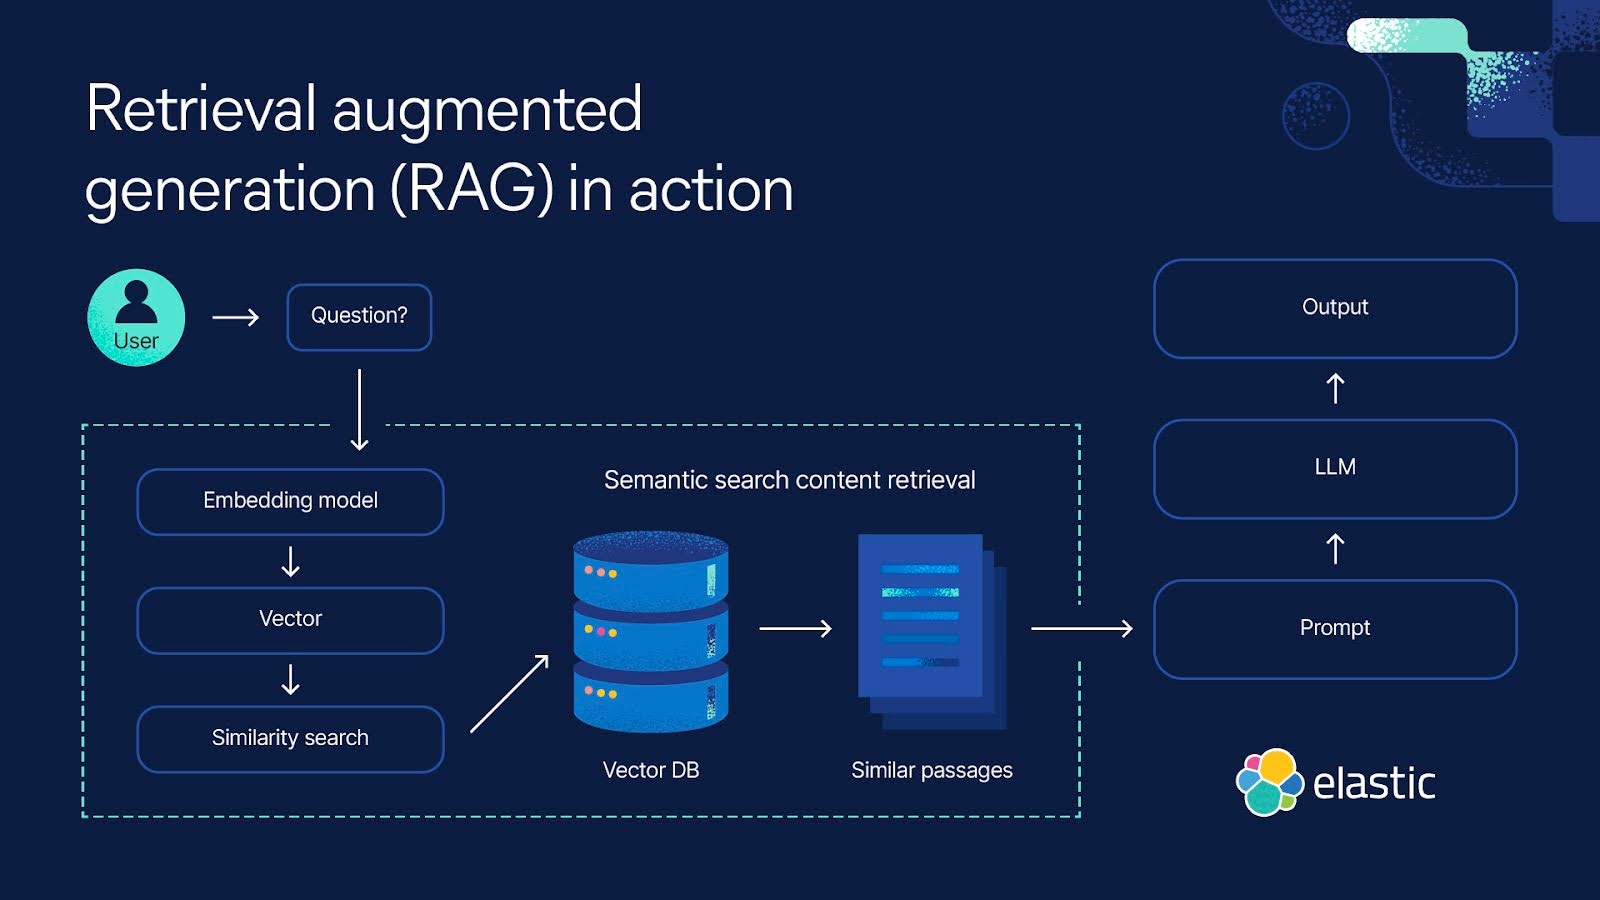

En esta notebook construiremos un modelo sencillo RAG para hacer consultas sobre información de los posgrados en la Universidad de Sonora. Usaremos el framework LangChain.

Comencemos haciendo algunas consultas con algunos LLMs. Preguntemos *¿cuánto dura la maestría en ciencia de datos de la universidad de sonora?*:

* ChatGPT.
* Algún modelo en Huggingface, [ejemplo](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct).
* Un modelo local.

¿Cuál es la diferencia entre ellos? ¿en qué radica el poder dar la respuesta correcta y relevante?

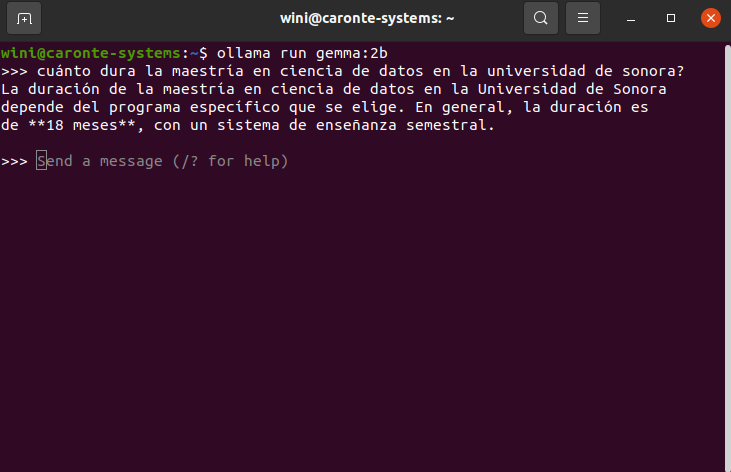

La respuesta es **RAG**. Veamos como funciona:

Instalamos los módulos necesarios

In [ ]:
!pip install pypdf                  # Leer archivos PDF
!pip install -U langchain-community # Third-party integrations for LangChain
!pip install -U langchain langchain-core langchain-community
# !pip install langchain              # Framework for developing applications powered by LLMs
!pip install chromadb               # Vector storage database

Bajar algunos documentos PDF

In [ ]:
!gdown 1sI80RrVCqGEGWkt2_K0N_q_c4mGquF7Q
!gdown 1eIoAGI4_YleCyynwzkLB-0DslwVYxiv0

## Leemos los documentos PDF

Leemos todos los documentos de la carpeta `path` en un arreglo de `Document`, cada uno de ellos contiene información sobre la ruta del archivo y el contenido de cada página.

`PyPDFDirectoryLoader` es una utilidad proporcionada por la biblioteca LangChain que se usa para cargar documentos PDF desde un directorio específico .

In [ ]:
# from langchain.document_loaders.pdf import PyPDFDirectoryLoader
from langchain_community.document_loaders import PyPDFDirectoryLoader

def load_documents(path):
    document_loader = PyPDFDirectoryLoader(path)
    return document_loader.load()

Especificamos la carpeta donde están los documentos:

In [ ]:
path = '/content'

documents = load_documents(path)
documents[1]

## Dividimos los documentos PDF en trozos

Usamos el [RecursiveCharacterTextSplitter](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain_text_splitters.character.RecursiveCharacterTextSplitter) de LangChain

In [ ]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain.schema.document import Document
from langchain_core.documents import Document

def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,           # Tamaño máximo de cada chunk en términos de número de caracteres
        chunk_overlap=80,         # Número de caracteres que se traslapan entre fragmentos consecutivos (para mantener contexto)
        length_function=len,      # Función utilizada para calcular la longitud del texto (en este caso, número de caracteres)
        is_separator_regex=False, # Indica si los separadores son expresiones regulares (False -> uso básico de saltos o divisores simples)
    )
    return text_splitter.split_documents(documents)

Separamos los documentos

In [ ]:
chunks = split_documents(documents)

Visualicemos algunos ejemplos de *chunks*

In [ ]:
print(chunks[0])
print(30*"-")
print(chunks[1])
print(30*"-")
print(chunks[2])

## Asignamos un embedding a cada trozo y almacenamos los embeddings en una base de datos

* [Bedrock embeddings](https://python.langchain.com/api_reference/aws/embeddings/langchain_aws.embeddings.bedrock.BedrockEmbeddings.html). Titan Embeddings de [AWS](https://aws.amazon.com/bedrock/?nc1=h_ls) (más [detalles](https://www.philschmid.de/amazon-titan-embeddings) de los embeddings).
* [HuggingFace embeddings](https://api.python.langchain.com/en/latest/huggingface/embeddings/langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings.html). Embeddings de [Sentence BERT](https://huggingface.co/sentence-transformers/all-mpnet-base-v2).
* [HuggingFaceBgeEmbeddings](https://python.langchain.com/api_reference/community/embeddings/langchain_community.embeddings.huggingface.HuggingFaceBgeEmbeddings.html) es una clase de la biblioteca LangChain diseñada para interactuar con modelos de embeddings de la familia BGE (Bidirectional General Encoder) alojados en Hugging Face, los cuales generan representaciones vectoriales del texto que permiten medir similitudes semánticas entre frases o documentos, los podemos usar en tareas como búsqueda semántica, clustering de textos o RAG.

In [ ]:
!pip install -qU langchain-huggingface

In [ ]:
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.embeddings.bedrock import BedrockEmbeddings
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
# from langchain.embeddings import HuggingFaceBgeEmbeddings

def get_embedding_function():
    # embeddings = BedrockEmbeddings(
    #     credentials_profile_name="default", region_name="us-east-1"
    # )
    # embeddings = OllamaEmbeddings(model="nomic-embed-text")
    # embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")
    return embeddings

Ahora definamos la base de datos de vectores. **ChromaDB** es una buena opción para trabajar con bases de datos vectoriales en entornos locales, también podrías considerar otras alternativas:

- **[ChromaDB](https://www.trychroma.com/)**: Ideal para proyectos que requieren simplicidad y facilidad de uso, especialmente en ambientes no escalables.
- **[FAISS (Facebook AI Similarity Search)](https://github.com/facebookresearch/faiss)**: Una alternativa muy eficiente si buscas velocidad en búsquedas vectoriales locales.

Ambas herramientas son útiles dentro del ecosistema RAG, pero la elección dependerá del contexto (si necesitas mayor rapidez o escalamiento).

In [ ]:
# from langchain.vectorstores.chroma import Chroma
from langchain_community.vectorstores import Chroma

CHROMA_PATH = "chroma"

def add_to_chroma(chunks: list[Document]):
    # Leer la DB existente
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=get_embedding_function()
    )

    # Calcular los IDs de chunks.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Agregar o actualizar documentos.
    existing_items = db.get(include=[])
    existing_ids = set(existing_items["ids"])
    print(f"Número de documentos existentes en la DB: {len(existing_ids)}")

    # Sólo agregar los documentos que no estén en la DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"Agregando {len(new_chunks)} nuevos documentos")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("No hay nuevos documentos para agregar")

def calculate_chunk_ids(chunks):

    # Función para crear los IDs de tipo "content/file.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        # Si el page ID es el mismo que el anterior, incrementar el índice
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calcular el chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks

La manera minimal de hacer esto es la siguiente, aunque no tenemos metadatos de los chunks, por defecto.

In [ ]:
from langchain_community.vectorstores import Chroma

CHROMA_PATH = "chroma"

def add_to_chroma(chunks):
    db = Chroma(
        persist_directory=CHROMA_PATH,
        embedding_function=get_embedding_function()
    )
    db.add_documents(chunks)   # ← LangChain crea ids y salta duplicados
    db.persist()

Contruimos o actualizamos la DB

In [ ]:
add_to_chroma(chunks)

## Interrogamos al LLM sobre cualquier tópico

Usaremos un LLM de transformers de HuggingFace.

Definimos el modelo:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-1.5B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype="auto",
    device_map="auto"
)

La función para interrogar al LLM con RAG

In [ ]:
import argparse

# from langchain.vectorstores.chroma import Chroma
# from langchain.prompts import ChatPromptTemplate

from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate

PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

def query_rag(query_text: str):
    # Preparar la DB
    embedding_function = get_embedding_function()
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Buscar en la DB
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n-----\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    # print(prompt)

    messages = [
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=256
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    sources = [doc.metadata.get("id", None) for doc, _score in results]
    formatted_response = f"------ Response ------\n{response_text}\n\n------  Sources ------ \n"
    print(formatted_response)
    # Listar las fuentes
    for source in sources:
        print(source)
    return response_text




Finalmente podemos hacer las consultas al LLM

In [ ]:
respuesta = query_rag("CUAL ES EL MECANISMO PARA GRADUARSE DE UNA MAESTRIA?")

In [ ]:
respuesta = query_rag("cuánto dura la maestría en ciencia de datos?")

In [ ]:
respuesta = query_rag("cuánto dura una maestría en la unison?")

In [ ]:
_ = query_rag("¿en qué consiste la maestría en ciencia de datos?'")

Verifiquemos que no inventa información cuando no existe la información en los documentos

In [ ]:
_ = query_rag("qué es un enlace ionico?'")

In [ ]:
_ = query_rag("¿en qué consiste la maestría en humanidades?'")

La calidad de las respuestas depende de:

* Documentos de consulta
* División de los documentos de consulta
* Embeddings
* Prompt
* LLM

¿Cómo podemos evaluar la calidad de este sistema?

## Further Reading and Techniques

* Curso Gratis de Nvidia: https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-15+V1
* Advanced RAG Techniques: Collection of RAG tutorials: https://github.com/NirDiamant/RAG_Techniques